In [11]:
from shapely.geometry import Polygon,Point
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from shapes import Circle,Rectangle
import numpy as np


In [2]:
class Domain2D():
    def __init__(self,base :Polygon ) -> None:
        self.operations ={'base_op_1':base}
        self.num_operations = 1 
        self.Domain = base
        self.bounds = self.Domain.bounds
        self.contains = self.Domain.contains
    def merge(self,*shapes,names = None):
        self.boolean_op(*shapes,names = names,op = 'add',inplace=True)
    def remove(self,*shapes,names= None):
        self.boolean_op(*shapes,names=names,op = 'sub',inplace=True)

    def boolean_op(self,*shapes,names=None,op = None,inplace = False):
        '''
        Operation to merge or remove shapes from existing combined into one as only difference is whether union or difference is called
        '''

        if op == 'add':
            oper = 'union'
        elif op == 'sub':
            oper = 'difference'

        if names is not None:
            assert len(shapes) == len(names)
        
        looper = shapes if names is None else zip(shapes,names)

        for val in looper:
            if names is None:
                shape = val                
            else:
                shape,ID = val
            
            print(shape)
            if isinstance(shape,Domain2D):
                shape = shape.Domain

            self.Domain = getattr(self.Domain,oper)(shape)
            #Update bounds
            self.bounds = self.Domain.bounds
            self.contains = self.Domain.contains
            
            self.num_operations += 1
            
            if names is None:
                ID = f'{op}_{str(shape.geom_type)}_op_{self.num_operations}'  
            self.operations[ID] = shape
        
        if not inplace:
            return self
    
    def create_boundary_group(self,shapeID,name):
        self.operations[name] = self.operations[shapeID].exterior

    def __getitem__(self,key):
        #Returns the coords of a part of the domain
        return self.operations[key]
    

    def triangulate_domain(self):
        '''
        Turn the domain into a set of triangles. Useful for sampling points from it
        '''
        
        

        

In [4]:

def naive_sampler(n,shape:Domain2D,MAX_ITER = 100):
    #Keep generating size n array
    n_generated = 0
    x1,y1,x2,y2 =shape.bounds
    #Someone teach me how to append arrays properly
    generated_list = []

    for _ in range(MAX_ITER):
        random_coords = np.column_stack((
            np.random.uniform(x1, x2, n),
            np.random.uniform(y1, y2, n)))
        
        points = map(Point,random_coords)
        
        valid_points = random_coords[list(map(shape.contains,points))] 
        n_generated += len(valid_points)
        generated_list.append(valid_points)
        if n_generated >= n:
            return np.concatenate(generated_list,axis = 0)[0:n]
        
        



(1, 2)

POLYGON ((1.5 0, 1.4999988234517019 -0.0015339801862848, 1.4999952938095762 -0.003067956762966, 1.4999894110819283 -0.0046019261204486, 1.499981175282601 -0.0061358846491545, 1.4999705864309743 -0.0076698287395311, 1.499957644551964 -0.0092037547820598, 1.499942349676024 -0.0107376591672645, 1.4999247018391446 -0.0122715382857199, 1.499904701082853 -0.0138053885280604, 1.4998823474542125 -0.0153392062849881, 1.499857641005824 -0.0168729879472817, 1.4998305817958233 -0.0184067299058048, 1.4998011698878844 -0.0199404285515144, 1.4997694053512154 -0.0214740802754695, 1.4997352882605617 -0.0230076814688394, 1.4996988186962041 -0.0245412285229123, 1.4996599967439592 -0.0260747178291039, 1.4996188224951785 -0.0276081457789657, 1.4995752960467492 -0.0291415087641937, 1.4995294175010931 -0.0306748031766366, 1.4994811869661668 -0.0322080254083046, 1.4994306045554617 -0.0337411718513776, 1.4993776703880028 -0.035274238898214, 1.4993223845883494 -0.0368072229413588, 1.4992647472865945 -0.03834012

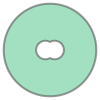

In [47]:
a = Circle((0,0),r =5)
b = Circle((-0.5,0),r =1)
c = Circle((0.5,0),r =1)


# f = Circle((2,1),r =1)


d = Domain2D(base = a)
e = Domain2D(base = b) 
e.merge(c)

d.remove(e,names = ['hole'])
d.Domain

d.create_boundary_group('hole','wall-1')
d.Domain



In [10]:
rectangle_coords = [(0, 0), (0, 4), (4, 4), (4, 0)]

# Create the outer rectangle as a polygon
rectangle = Polygon(rectangle_coords)


POLYGON ((-0.5 1, -0.5 2, 0.5 2, 0.5 1, -0.5 1))


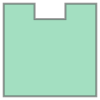

In [12]:
a = Rectangle(((0,0),3,3),'midpoint')
b = Rectangle(((0,1.5),1,1),'midpoint')

c = Domain2D(base = a)
c.remove(b,names = ['hole'])
c.Domain

In [13]:
def remove_tri_holes(triangulation,shape:Polygon):
    points = triangulation.points
    triangles = triangulation.simplices
    
    if isinstance(shape,Domain2D):
        shape = shape.Domain

    def tri_in_shape(points,triangles):
        for triangle in triangles:
            #I have an array of the points [p1,p2,p3] which is the index
            tri_points = points[triangle]
            tri = Polygon(tri_points)
            yield shape.contains(tri) 

    tri_mask = [tri_check for tri_check in  tri_in_shape(points,triangles)]
    return triangles[tri_mask]


In [14]:
def triangulate_shape(shape,show_plot = False):
    '''
    Triangulate an arbitary shape using Delaunay Alogorithim from SciPy.

    Args:
    shape: Polygon | Domain2D -> Shape;y object to triangulate
    show_plot: bool (Default : False) -> display the triangulated shapes

    Returns:
    points : np.array -> array of (x,y) co-ordinates of each vertex in the shape of size (N,2)
    triangles : np.array -> an (N,3) array. Each row indicates the index of the 3 points in the points array that makeup the triangle

    Example: triangles[0] = [0,2,3] means that the 1st triangle made from points[0],points[2] and points[3]
    '''
    if isinstance(shape,Domain2D):
        shape =shape.Domain
    
    vertices = list(shape.exterior.coords)
    holes = [list(hole.coords) for hole in shape.interiors]
    all_vertices = np.array(vertices + [v for hole in holes for v in hole])
    # Create the Delaunay triangulation
    triangulation = Delaunay(all_vertices)

    #Find all triangles that is contained within the shape
    triangles = remove_tri_holes(triangulation,shape)
    points = triangulation.points
    #PLot Results. Note avoid plotting circles (these are technically a high n-sided polygon)
    if show_plot:        
        # Prepare data for plotting
        plt.triplot(all_vertices[:,0], all_vertices[:,1], triangles)
        plt.plot(all_vertices[:,0], all_vertices[:,1], 'o')
        plt.show()


    return points,triangles


def triangle_proportion(points,triangles):
    '''
    Return the proportion of total area that each triangle comprises of.
    '''
    areas = [Polygon(points[triangle]).area for triangle in triangles]
    total_area = sum(areas)
    probs = [area/total_area for area in areas]
    return np.array(probs)


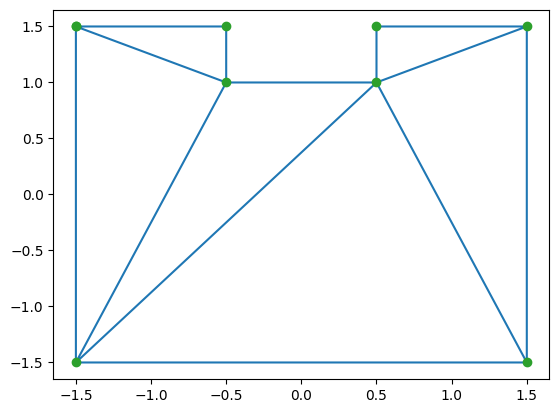

POLYGON ((-0.5 1, -0.5 1.5, -1.5 1.5, -0.5 1))
POLYGON ((0.5 1, 1.5 -1.5, 1.5 1.5, 0.5 1))
POLYGON ((0.5 1.5, 0.5 1, 1.5 1.5, 0.5 1.5))
POLYGON ((0.5 1, -1.5 -1.5, 1.5 -1.5, 0.5 1))
POLYGON ((-1.5 -1.5, 0.5 1, -0.5 1, -1.5 -1.5))


8.5

In [16]:
points,t2 = triangulate_shape(c,show_plot=True)

p = points[t2[0]]
f = Domain2D(base = Polygon(p))
for tri_points in t2[1:]:
    p = points[tri_points]
    f.merge(Polygon(p))
f.Domain
f.Domain.area

In [26]:
points

array([[-1.5,  1.5],
       [-0.5,  1.5],
       [-0.5,  1. ],
       [ 0.5,  1. ],
       [ 0.5,  1.5],
       [ 1.5,  1.5],
       [ 1.5, -1.5],
       [-1.5, -1.5],
       [-1.5,  1.5]])

In [39]:
probs = triangle_proportion(points,t2)


def sample_triangles(triangles,n,probs):    
    indices = np.arange(len(triangles))
    return np.random.choice(indices,size = n, p = probs)

def gen_point_in_triangle(points,triangle,U1,U2):
    coords = points[triangle]
    a =  coords[1]-coords[0]
    b =  coords[2]-coords[0]
    return U1*a + U2*b



U = np.random.rand(500,2)

def Generate_points(triangles,n):
    
    indices = sample_triangles(points,triangles,n)


    U = np.random.rand(n,2)
    #Reflection of points see link for explanation
    U[U[:,0] + U[:,1] > 1 ] = 1-U[U[:,0] + U[:,1] > 1]



In [30]:
U[U[:,0] + U[:,1] > 1 ] = 1-U[U[:,0] + U[:,1] > 1]

In [49]:
i  = sample_triangles(t2,500,probs)

#G
sampled_tri = t2[i]
print(sampled_tri)
a = sampled_tri[:,1]-sampled_tri[:,0]
b =  sampled_tri[:,2]-sampled_tri[:,0]

U = np.random.rand(500,2)
U[U[:,0] + U[:,1] > 1 ] = 1-U[U[:,0] + U[:,1] > 1]

a*U[:,0] + b*U[:,1]



[[3 7 6]
 [7 3 2]
 [3 6 5]
 ...
 [7 3 2]
 [7 2 0]
 [3 7 6]]


array([ 3.12528049, -4.22957466,  1.91339808,  2.33093953, -5.78645923,
        1.43514566,  3.61031751,  1.33033893, -1.59047223,  3.16644495,
       -3.12322934,  1.52345285,  2.00799779, -0.50068411,  1.84233993,
        3.33931693,  1.99633682,  1.67799468,  2.94047491,  0.41725809,
        2.54308925, -3.37436911,  2.98669128,  2.1076868 ,  0.92965091,
       -3.99301022, -2.98563924,  1.17352905, -0.41341262,  3.53063098,
        1.64940326, -0.78477791, -0.45349019,  2.67865612,  1.56697525,
        0.71493673, -3.75224376, -3.36972891,  2.302086  ,  3.1155481 ,
        1.4923405 ,  0.8721298 , -4.30964151,  3.21558506,  2.43300798,
        2.54721928,  0.85607936, -1.22810819, -4.76348759, -4.41043138,
        1.79731642,  1.0439573 , -1.5275992 ,  1.33626503, -2.0943778 ,
       -5.26143162,  2.91299795,  3.65531871,  3.03487487, -2.12580277,
       -2.771063  ,  2.73438675, -2.82024148,  1.8778132 ,  1.30019624,
        2.67389416,  0.87480835,  1.93770988, -3.63724447, -3.07